wandb:   1 of 1 files downloaded.  


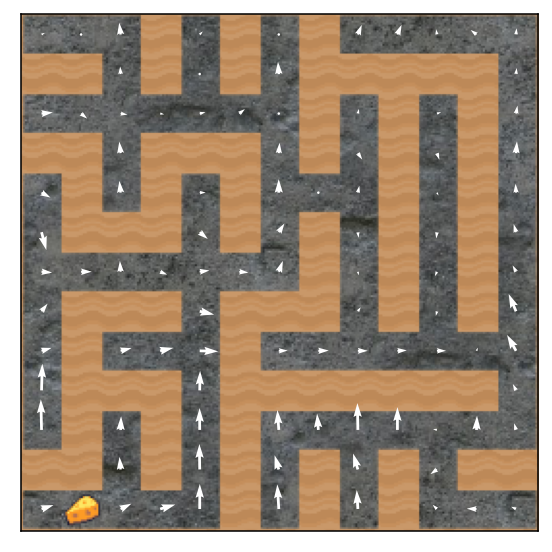

In [2]:
import wandb
from tqdm import tqdm
import torch
from procgen_tools import maze, visualization, models
import os
import shutil
import matplotlib.pyplot as plt

def get_model_number(model_name):
    # model is of format model_<number>:v<version>
    return int(model_name.split('_')[1].split(':')[0])

# Set your specific run ID here
run_id = "jp9tjfzd"
project_name = "procgen"

# Initialize wandb API
api = wandb.Api()

# Fetch the run
run = api.run(f"{project_name}/{run_id}")

# List all artifacts for this run
artifacts = run.logged_artifacts()
artifacts_list = [artifact for artifact in artifacts]
artifact = artifacts_list[-1]
artifact_to_download = api.artifact(f"{project_name}/{artifact.name}", type="model")
artifact_dir = artifact_to_download.download()
model_file = f"{artifact_dir}/{artifact.name[:-3]}.pth"
model = torch.load(model_file)
if "state_dict" in model:
    model["model_state_dict"] = model.pop("state_dict")
torch.save(model, model_file)
model = models.load_policy(model_file, 15, torch.device("cuda:0"))
venv = maze.create_venv(1, start_level=0, num_levels=1)
env_state = maze.state_from_venv(venv, 0)
maze.move_cheese_in_state(env_state, (6,7))
venv.env.callmethod('set_state', [env_state.state_bytes])
venv.reset()

vf_original = visualization.vector_field(venv, model)
# Save each plot as an image
visualization.plot_vf(vf_original)
plt.show()

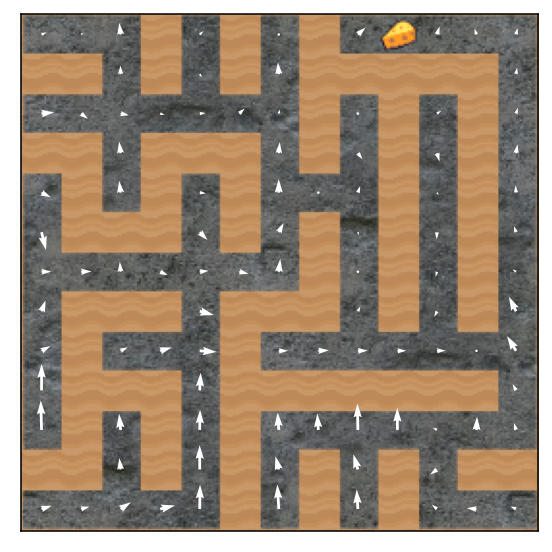

In [21]:
venv = maze.create_venv(1, start_level=0, num_levels=1)
env_state = maze.state_from_venv(venv, 0)
maze.move_cheese_in_state(env_state, (18,15))
venv.env.callmethod('set_state', [env_state.state_bytes])
venv.reset()

vf_original = visualization.vector_field(venv, model)
# Save each plot as an image
visualization.plot_vf(vf_original)
plt.show()

In [1]:
def get_model_number(model_name):
    # model is of format model_<number>:v<version>
    return int(model_name.split('_')[1].split(':')[0])

In [10]:
import wandb
from tqdm import tqdm
import torch
from procgen_tools import maze, visualization, models
import os
import shutil
import matplotlib.pyplot as plt
# Set your specific run ID here
run_id = "jp9tjfzd"
project_name = "procgen"

# Initialize wandb API
api = wandb.Api()

# Fetch the run
run = api.run(f"{project_name}/{run_id}")

# List all artifacts for this run
artifacts = run.logged_artifacts()
for artifact in tqdm(artifacts):
    artifact_to_download = api.artifact(f"{project_name}/{artifact.name}", type="model")
    artifact_dir = artifact_to_download.download()
    model_file = f"{artifact_dir}/{artifact.name[:-3]}.pth"
    model = torch.load(model_file)
    if "state_dict" in model:
        model["model_state_dict"] = model.pop("state_dict")
    torch.save(model, model_file)
    model = models.load_policy(model_file, 15, torch.device("cuda:0"))
    venv = maze.create_venv(1, start_level=0, num_levels=1)
    vf_original = visualization.vector_field(venv, model)
    frames_dir = f"/workspace/maze-values-dev-interp/procgen-tools-dev-interp/experiments/frames"
    os.makedirs(frames_dir, exist_ok=True)
    # Save each plot as an image
    frame_filename = os.path.join(frames_dir, f"frame_{get_model_number(artifact.name)}.png")
    visualization.plot_vf(vf_original)
    plt.savefig(frame_filename)
    plt.close()
    # delete model file
    shutil.rmtree(artifact_dir)

  0%|          | 5/3282 [00:20<3:46:36,  4.15s/it]


KeyboardInterrupt: 

In [ ]:
import os
import glob
import torch
from procgen_tools import maze, visualization, models
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
model_files = glob.glob("/workspace/maze-values-dev-interp/procgen-tools-dev-interp/experiments/logs/procgen/maze_aisc/hard-run/seed_712_13-01-2024_07-29-19/logs/procgen/maze_aisc/hard-run/seed_712_13-01-2024_07-29-19/*.pth")
print(model_files)
# sort by modification time
model_files.sort(reverse=False)
frames_dir = "/workspace/frames"
i = 0
os.makedirs(frames_dir, exist_ok=True)
for model_file in tqdm(model_files):
    # loading to torch
    # Load the model file and print its keys
    checkpoint = torch.load(model_file, map_location=torch.device('cpu'))
    if "state_dict" in checkpoint:
        checkpoint['model_state_dict'] = checkpoint.pop("state_dict")
    torch.save(checkpoint, model_file)
    # try to load to cuda, if that doesn't work try to load to cpu
    try:
        policy = models.load_policy(model_file, 15, torch.device('cpu'))  # Adjust parameters as needed
    except:
        print("Loading to cuda failed, loading to cpu...")
        policy = models.load_policy(model_file, 15, torch.device('cpu'))

    venv = maze.create_venv(1, start_level=0, num_levels=1)
    vf_original = visualization.vector_field(venv, policy)
    
    # Save each plot as an image
    frame_filename = os.path.join(frames_dir, f"frame_{i}.png")
    i += 1
    visualization.plot_vf(vf_original)
    plt.savefig(frame_filename)
    plt.close()


In [ ]:
import os
import glob
import re
from moviepy.editor import ImageSequenceClip

frames_dir = "/workspace/frames"

# Function to extract the frame number from the filename
def extract_number(f):
    s = re.findall("\d+", f)
    return (int(s[0]) if s else -1, f)

# Sort frame files numerically
frame_files = sorted(glob.glob(os.path.join(frames_dir, "*.png")), key=extract_number, reverse=True)

# Create video clip
clip = ImageSequenceClip(frame_files, fps=4)  # Adjust fps
clip.write_videofile('/workspace/policy_evolution.mp4', codec='libx264')

# Display the video (in Jupyter notebooks)
from IPython.display import Video
Video('/workspace/policy_evolution.mp4')


In [ ]:
from IPython.display import Video

Video("/workspace/policy_evolution.mp4")

In [ ]:
# Create GIF
frame_files = sorted(glob.glob(os.path.join(frames_dir, "*.png")), key=lambda x: os.path.getmtime(x))
images = [imageio.imread(filename) for filename in frame_files]
imageio.mimsave('policy_evolution.gif', images, fps=4)  # Adjust fps

from IPython.display import Image
Image(filename='policy_evolution.gif')

In [ ]:
import torch as t
from procgen_tools import maze, vfield, models

# Load pretrained policy
policy = models.load_policy('trained_models/maze_I/model_rand_region_5.pth', 15, t.device('cpu'))
venv = maze.create_venv(1, start_level=0, num_levels=1)
vf_original = vfield.vector_field(venv, policy)
vfield.plot_vf(vf_original)
plt.show()